In [1]:
## Load in needed mods
import numpy as np, pandas as pd, scipy.stats as ss, seaborn as sns
from sklearn import feature_selection as fs
from matplotlib import pyplot as plt
%matplotlib inline

## Set random seed
np.random.seed(7111991)

## Set phenotype of interest 
newpheno_label = 'Quadrary'

## Set paths
## Phenotype path (you'll need to change this)
phenopath = '../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype_QTL.csv'

## load phenotype
pheno = pd.read_csv(phenopath)

## Sort values
pheno.sort_values(by=['RIC8','RHO','MAT',newpheno_label],inplace=True)

## set index
pheno.index = pheno.Genotyped

## Set observed MI, y-value
yobs = 100

## Set samples to use and print number of
samples = pheno.Genotyped.values

assert len(samples) == 73, "We are missing samples"

pheno.head()

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quadrary,Genotyped,Clone,IRK7,RIC8,RHO,MAT
Genotyped,,,,,,,,,,,,,,
A03,A_03,1.0,N,0.0,Yeast,0.0,0.0,0.0,A03,0,0.0,0.0,0.0,0.0
A10,A_10,3.0,N,0.0,Yeast,0.0,0.0,0.0,A10,0,0.0,0.0,0.0,0.0
A14,A_14,4.0,N,0.0,Yeast,0.0,0.0,0.0,A14,0,0.0,0.0,0.0,0.0
A25,A_25,4.0,N,0.0,Yeast,0.0,0.0,0.0,A25,0,0.0,0.0,0.0,0.0
A30,A_30,1.0,N,0.0,Yeast,0.0,0.0,0.0,A30,0,0.0,0.0,0.0,0.0


In [2]:
from sklearn.metrics import mutual_info_score as mis

In [3]:
pheno['Y_mat'] = pheno[newpheno_label] + 0.25*pheno.MAT

In [4]:
## Set MAT lables
## For MATalpha
matal = '$MAT\mathrm{\u03B1}$'

## MATa
mata =  r'$MAT\bf{a}$'

In [5]:
pheno_labels = [ '\n'.join(l.split(' ')) if len(l.split(' '))>1 else l for l in pheno.Phenotype_Description.unique()]

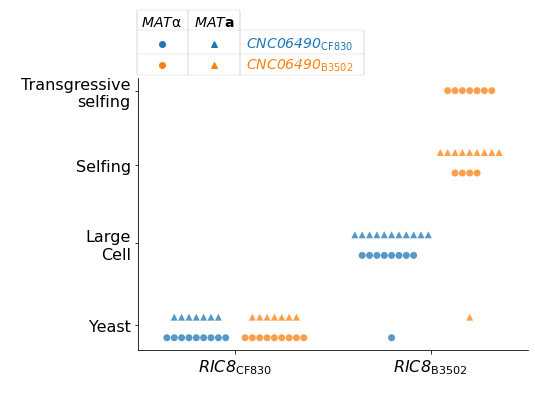

In [6]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
fig.set_facecolor('w')
[sns.swarmplot(x='RIC8',y='Y_mat',
              data=pheno[(pheno.MAT==k)],
              hue='RHO',dodge=True,
               size=7,alpha=0.75,
               marker='o' if k == 0 else '^') for k in [0,1]]

leg = plt.legend()

ax.get_legend().remove()

## Add y and x tick lables
plt.yticks(np.arange(4)+np.array([0.15,0.15,0.1,0]),pheno_labels,fontsize=16);plt.ylabel(' ');
plt.xticks([0,1],[r'RIC8$_{\rm{CF830}}$',r'RIC8$_{\rm{B3502}}$'],fontstyle='italic',fontsize=16);plt.xlabel(' ');

[ax.spines[t].set_visible(False) for t in ['top','right']]


az = fig.add_axes([0.1,0.88,0.5,0.2])
plt.axis('off')

## Make our own legend
plt.plot(-0.1,2.8,'^',color='tab:blue')
plt.plot(-0.35,2.8,'o',color='tab:blue')
plt.text(0.05,2.8,r'CNC06490$_{\rm{CF830}}$',style='italic',va='center',ha='left',color='tab:blue',fontsize=14)

plt.text(-0.1,3.12,mata,fontsize=14,va='center',ha='center')
plt.text(-0.35,3.12,matal,fontsize=14,va='center',ha='center')

plt.plot(-0.1,2.5,'^',color='tab:orange')
plt.plot(-0.35,2.5,'o',color='tab:orange')
plt.text(0.05,2.5,r'CNC06490$_{\rm{B3502}}$',style='italic',va='center',ha='left',color='tab:orange',fontsize=14)

plt.vlines([np.mean([-0.1,-0.35]),-0.47,0.02,0.61],2.35,3.3,color='k',alpha=0.1,linestyle='-')
plt.hlines([2.65,2.35,3,3.3],-0.47,0.61,linestyle='-',color='grey',alpha=0.1);

plt.hlines(3.3,0.0201,0.62,color='w',linewidth=2)
plt.vlines(0.61,3.01,3.3,color='w',linewidth=2)

plt.savefig('../FIGURES/Selfing_phenotype_by_QTL.png',dpi=400,bbox_inches='tight');

In [7]:
## Here we are using the quadrary (4) phenotype to
## search for interatons between RIC8, RHO, and MAT
## locus that lead to transgressive selffing phenotype

## Gather the phenotypes coded 0 - 3
Y = pheno.loc[samples,newpheno_label].values.reshape(-1,1)

## Main loci to test, the MAT type (coded 0 or 1)
## and genotypes at QTL3 (putatitve RHO) and RIC8
MAT = pheno.loc[samples,'MAT'].values.reshape(-1,1)
RHO = pheno.loc[samples,'RHO'].values.reshape(-1,1)
RIC8 = pheno.loc[samples,'RIC8'].values.reshape(-1,1)
irk7 = pheno.loc[samples,'IRK7'].values.reshape(-1,1)

## Encode two-locus genotypes
MATRHO = MAT + 2 * RHO
MATRIC8 = MAT + 2 * RIC8
RHORIC8 = RHO + 2 * RIC8

## Encode three-locus genotypes
MATRHORIC8 = MAT + 2*RHO + 4*RIC8

## Run MI code, this is using natrual log (nats)
MIobs = fs.mutual_info_classif(np.hstack((Y,
                                  MAT,RHO,RIC8,
                                  MATRHO, MATRIC8, RHORIC8,
                                  MATRHORIC8,irk7)), Y.ravel(),
                                  discrete_features=True)

## label MIs
MI_MAT = MIobs[1]
MI_RHO = MIobs[2]
MI_RIC8 = MIobs[3]
MI_MATRHO = MIobs[4]
MI_MATRIC8 = MIobs[5]
MI_RHORIC8 = MIobs[6]
MI_MATRHORIC8 = MIobs[7]
MI_irk7 = MIobs[8]

## Gather entropy of Y
entropy_Y = MIobs[0]

## Calculate IGstrict of Hu et al
IG_MATRHO = MI_MATRHO - MI_MAT - MI_RHO
IG_MATRIC8 = MI_MATRIC8 - MI_MAT - MI_RIC8
IG_RHORIC8 = MI_RHORIC8 - MI_RHO - MI_RIC8
IG_MATRHORIC8 =  MI_MATRHORIC8 - np.maximum(IG_MATRHO, 0) \
    - np.maximum(IG_MATRIC8,0) \
    - np.maximum(IG_RHORIC8, 0) \
    - MI_MAT - MI_RHO - MI_RIC8

In [8]:
IG_MATRHO, IG_RHORIC8, IG_MATRIC8

(-5.58921926874234e-06, -7.324386374163439e-05, -0.002553082950156549)

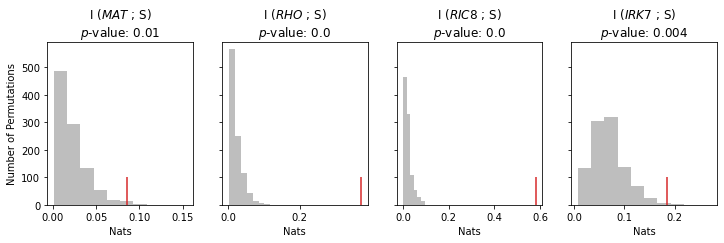

In [9]:
## Cunduct permutation testing
## Test for main effects
MIperm = []
nperms = 1000

while len(MIperm) < nperms:
    origgenos = np.hstack((MAT,RHO,RIC8,irk7))
    permgenos = np.random.permutation(origgenos)
    
    ## Gather permutation of each locus
    pMAT = permgenos[:,0].reshape(-1,1)
    pRHO = permgenos[:,1].reshape(-1,1)
    pRIC8 = permgenos[:,2].reshape(-1,1)
    pirk7 = permgenos[:,3].reshape(-1,1)
    
    pMATRHO = pMAT + 2*pRHO
    pMATRIC8 = pMAT + 2*pRIC8
    pRHORIC8 = pRHO + 2*pRIC8
    pMATRHORIC8 = pMAT + 2*pRHO + 4*pRIC8    
    
    miperm = fs.mutual_info_classif(np.hstack((Y,pMAT, pRHO, pRIC8,
                                               pMATRHO, pMATRIC8, pRHORIC8,
                                               pMATRHORIC8)), Y.ravel(),
                                    discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)

MI_pMAT = MIperm[:,1]
MI_pRHO = MIperm[:,2]
MI_pRIC8 = MIperm[:,3]
MI_pirk7 = MIperm[:,4]

## List MI, permuted MI, and labels for plotting
MI = [MI_MAT, MI_RHO,MI_RIC8,MI_irk7]
MIp = [MI_pMAT,MI_pRHO,MI_pRIC8,MI_pirk7]
MI_labels = ['MAT','RHO','RIC8','IRK7']

## Call figure and set facecolor
fig,ax = plt.subplots(1,len(MI_labels),figsize=(12,3), sharey=True)
fig.set_facecolor('w')

## Iterate overthe three MI
for i,mi in enumerate(MI):
    
    ## Calcualte p-value
    pval = np.round(np.sum(MIp[i] > mi)/float(len(MIp[i])),3)
    
    ## Set axis
    plt.sca(ax[i])
    
    ## Plot null MI
    plt.hist(MIp[i],color='tab:grey',alpha=0.5)
    
    ## Plot observed MI
    plt.vlines(mi,0,yobs,color='tab:red')
    
    ## Set title, x and y lables
    plt.title('I ($%s$ ; S)\n$p$-value: %s'%(MI_labels[i],pval))
    plt.xlabel('Nats')
    plt.ylabel('Number of Permutations' if i == 0 else None)

In [10]:
pRHO.shape

(73, 1)

In [11]:
len(samples)

73

In [12]:
np.unique(Y)

array([0., 1., 2., 3.])

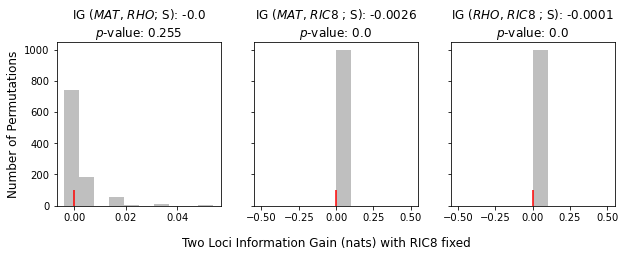

In [13]:
## Run permutation for TWO-way effects
## with RIC8 fixed
MIperm = []

Y = pheno.loc[samples,newpheno_label].values.reshape(-1,1)

while len(MIperm) < nperms:
    
    ## Permute MAT based on RIC8
    pMAT = np.concatenate([np.random.permutation(MAT[(RIC8==r) & (Y==y)]) for r in [0,1] for y in np.unique(Y)]).reshape(-1,1)
    
    ## Permute RHO based on RIC8
    pRHO = np.concatenate([np.random.permutation(RHO[(RIC8==r) & (Y==y)]) for r in [0,1] for y in np.unique(Y)]).reshape(-1,1)
    
    ## FIX RIC8
    pRIC8 = RIC8
    
    ## Code phenotypes
    pY = np.concatenate([[y]*len(MAT[(RIC8==r) & (Y==y)]) for r in [0,1] for y in np.unique(Y)]).reshape(-1,1)

    pMATRHO = pMAT + 2*pRHO
    pMATRIC8 = pMAT + 2*pRIC8
    pRHORIC8 = pRHO + 2*pRIC8
    pMATRHORIC8 = pMAT + 2*pRHO + 4*pRIC8   
    
    
    ## Run MI analysis
    miperm = fs.mutual_info_classif(np.hstack((pY,
                                  pMAT, pRHO, pRIC8,
                                  pMATRHO, pMATRIC8, pRHORIC8,
                                  pMATRHORIC8)),pY.ravel(),discrete_features=True)
    ## Append results
    MIperm.append(miperm)
    
## Make into an array
MIperm = np.array(MIperm)
    
## List arrays    
MI_pMAT = MIperm[:,1]
MI_pRHO = MIperm[:,2]
MI_pRIC8 = MIperm[:,3]
MI_pMATRHO = MIperm[:,4]
MI_pMATRIC8 = MIperm[:,5]
MI_pRHORIC8 = MIperm[:,6]

# Two-way IGstrict for permuted data
IG_pMATRHO_rf = MI_pMATRHO - MI_pMAT - MI_pRHO
IG_pMATRIC8_rf = MI_pMATRIC8 - MI_pMAT - MI_pRIC8
IG_pRHORIC8_rf = MI_pRHORIC8 - MI_pRHO - MI_pRIC8

## Plot results
## Call figure
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(IG_pMATRHO_rf,color='grey',alpha=0.5)
plt.vlines(IG_MATRHO, ymin=0, ymax=100, color='r')
plt.ylabel('Number of Permutations',fontsize=12)
k = np.sum(IG_pMATRHO_rf > IG_MATRHO)/float(len(IG_pMATRHO_rf))
plt.title("IG ($MAT$, $RHO$; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRHO,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[1])
plt.hist(IG_pMATRIC8_rf,color='grey',alpha=0.5)
plt.vlines(IG_MATRIC8, ymin=0, ymax=100, color='r')
k = np.sum(IG_pMATRIC8_rf > IG_MATRIC8)/float(len(IG_pMATRIC8_rf))
plt.title("IG ($MAT$, $RIC8$ ; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRIC8,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[2])
plt.hist(IG_pRHORIC8_rf,color='grey',alpha=0.5)
plt.vlines(IG_RHORIC8, ymin=0, ymax=100, color='r')
k = np.sum(IG_pRHORIC8_rf > IG_RHORIC8)/float(len(IG_pRHORIC8_rf))
plt.title("IG ($RHO$, $RIC8$ ; S): %s\n$p$-value: %s"%(
    str(np.round(IG_RHORIC8,4)),
    str(np.round(k,4))),fontsize=12)

fig.text(x=0.5,y=-0.05,s='Two Loci Information Gain (nats) with RIC8 fixed',
         fontsize=12,va='center',ha='center');

In [14]:
IG_MATRIC8

-0.002553082950156549

In [15]:
np.max(IG_pMATRIC8_rf)

-0.002553082950156549

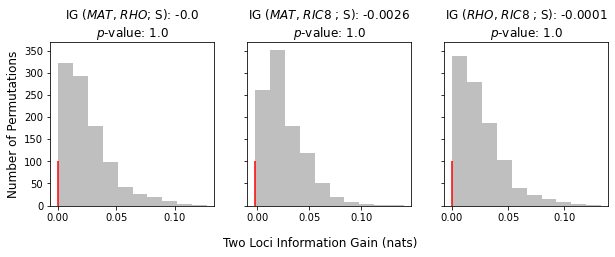

In [16]:
## Run permutations with full data, no fixed point
MIperm = []

for i in range(1000):
    origgenos = np.hstack((MAT,RHO,RIC8))
    permgenos = np.random.permutation(origgenos)
    pMAT = permgenos[:,0]
    pRHO = permgenos[:,1]
    pRIC8 = permgenos[:,2]
    pMAT = pMAT.reshape(-1,1)
    pRHO = pRHO.reshape(-1,1)
    pRIC8 = pRIC8.reshape(-1,1)
    pMATRHO = pMAT + 2*pRHO
    pMATRIC8 = pMAT + 2*pRIC8
    pRHORIC8 = pRHO + 2*pRIC8
    pMATRHORIC8 = pMAT + 2*pRHO + 4*pRIC8    
    
    miperm = fs.mutual_info_classif(np.hstack((Y,
                                  pMAT,pRHO,pRIC8,
                                  pMATRHO, pMATRIC8, pRHORIC8,
                                  pMATRHORIC8)), Y.ravel(),
                                  discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pMAT = MIperm[:,1]
MI_pRHO = MIperm[:,2]
MI_pRIC8 = MIperm[:,3]
MI_pMATRHO = MIperm[:,4]
MI_pMATRIC8 = MIperm[:,5]
MI_pRHORIC8 = MIperm[:,6]
MI_pMATRHORIC8 = MIperm[:,7]

zeros = np.zeros_like(MI_pMAT)

# IGstrict for permuted data
IG_pMATRHO = MI_pMATRHO - MI_pMAT - MI_pRHO
IG_pMATRIC8 = MI_pMATRIC8 - MI_pMAT - MI_pRIC8
IG_pRHORIC8 = MI_pRHORIC8 - MI_pRHO - MI_pRIC8
IG_pMATRHORIC8 =  MI_pMATRHORIC8 - np.maximum(IG_pMATRHO, zeros) \
    - np.maximum(IG_pMATRIC8, zeros) \
    - np.maximum(IG_pRHORIC8, zeros) \
    - MI_pMAT - MI_pRHO - MI_pRIC8

## Plot results
## Call figure
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(IG_pMATRHO,color='grey',alpha=0.5)
plt.vlines(IG_MATRHO, ymin=0, ymax=100, color='r')
plt.ylabel('Number of Permutations',fontsize=12)
k = np.sum(IG_pMATRHO > IG_MATRHO)/float(len(IG_pMATRHO))
plt.title("IG ($MAT$, $RHO$; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRHO,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[1])
plt.hist(IG_pMATRIC8,color='grey',alpha=0.5)
plt.vlines(IG_MATRIC8, ymin=0, ymax=100, color='r')
k = np.sum(IG_pMATRIC8 > IG_MATRIC8)/float(len(IG_pMATRIC8))
plt.title("IG ($MAT$, $RIC8$ ; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRIC8,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[2])
plt.hist(IG_pRHORIC8,color='grey',alpha=0.5)
plt.vlines(IG_RHORIC8, ymin=0, ymax=100, color='r')
k = np.sum(IG_pRHORIC8 > IG_RHORIC8)/float(len(IG_pRHORIC8))
plt.title("IG ($RHO$, $RIC8$ ; S): %s\n$p$-value: %s"%(
    str(np.round(IG_RHORIC8,4)),
    str(np.round(k,4))),fontsize=12)

fig.text(x=0.5,y=-0.05,s='Two Loci Information Gain (nats)',
         fontsize=12,va='center',ha='center');

IG ( $MAT, RHO, RIC8$ ; S ): 0.015
p-value: 0.0


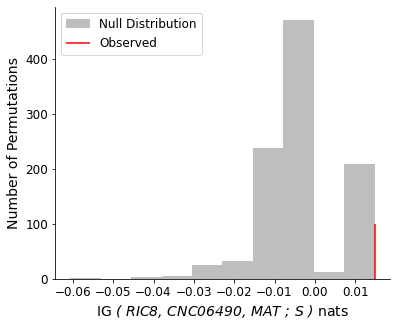

In [17]:
## Run permutation for higher order effects
## With main effects fixed
MIperm = []

Y = pheno.loc[samples,newpheno_label].values.reshape(-1,1)
uniq_y = sorted(np.unique(Y))

while len(MIperm) < nperms:
    origgenos = np.hstack((MAT,RHO,RIC8))
    
    pMAT = np.concatenate([np.random.permutation(MAT[(Y==y)]) for y in uniq_y]).reshape(-1,1)
    pRHO = np.concatenate([np.random.permutation(RHO[(Y==y)]) for y in uniq_y]).reshape(-1,1)
    pRIC8 = np.concatenate([np.random.permutation(RIC8[(Y==y)]) for y in uniq_y]).reshape(-1,1)
    pY = np.concatenate([[y]*len(RIC8[Y==y]) for y in uniq_y]).reshape(-1,1)

    pMATRHO = pMAT + 2*pRHO
    pMATRIC8 = pMAT + 2*pRIC8
    pRHORIC8 = pRHO + 2*pRIC8
    pMATRHORIC8 = pMAT + 2*pRHO + 4*pRIC8    
    
    miperm = fs.mutual_info_classif(np.hstack((pY,
                                  pMAT, pRHO, pRIC8,
                                  pMATRHO, pMATRIC8, pRHORIC8,
                                  pMATRHORIC8)),pY.ravel(),
                                  discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pMAT = MIperm[:,1]
MI_pRHO = MIperm[:,2]
MI_pRIC8 = MIperm[:,3]
MI_pMATRHO = MIperm[:,4]
MI_pMATRIC8 = MIperm[:,5]
MI_pRHORIC8 = MIperm[:,6]
MI_pMATRHORIC8 = MIperm[:,7]

zeros = np.zeros_like(MI_pMAT)

# IGstrict for permuted data
IG_pMATRHO = MI_pMATRHO - MI_pMAT - MI_pRHO
IG_pMATRIC8 = MI_pMATRIC8 - MI_pMAT - MI_pRIC8
IG_pRHORIC8 = MI_pRHORIC8 - MI_pRHO - MI_pRIC8
IG_pMATRHORIC8_mf =  MI_pMATRHORIC8 - np.maximum(IG_pMATRHO, zeros) \
    - np.maximum(IG_pMATRIC8, zeros) \
    - np.maximum(IG_pRHORIC8, zeros) \
    - MI_pMAT - MI_pRHO - MI_pRIC8

## Examine three way interactioin null dist
## make lable
myxlabel = r'$\rm{IG}$ '+'( RIC8, CNC06490, MAT ; S )' + r' $\rm{nats}$'

## call figure
fig,ax = plt.subplots(1,1,figsize=(6,5))

## Calculate pvalue for three loci interaction
three_way_pval = np.round(np.sum(IG_pMATRHORIC8_mf > IG_MATRHORIC8)/float(len(IG_pMATRHORIC8_mf)),3)

## plot null dist
plt.hist(IG_pMATRHORIC8_mf,color='tab:grey',alpha=0.5,label='Null Distribution')

## Plot observed IG
plt.vlines(IG_MATRHORIC8, ymin=0, ymax=100,color='r',label='Observed')

## print p-value and statistic
print("IG ( $MAT, RHO, RIC8$ ; S ): %s\np-value: %s"%(
    np.round(IG_MATRHORIC8,3), three_way_pval ))

## Add legend
plt.legend(fontsize=12);plt.xticks(fontsize=12);plt.yticks(fontsize=12)

## add x and y labels
plt.xlabel(myxlabel,fontstyle='italic',fontsize=14)
plt.ylabel('Number of Permutations',fontsize=14);

[ax.spines[t].set_visible(False) for t in ['top','right']]

plt.savefig('../FIGURES/Three-way_IG_nulldist.png',dpi=400,bbox_inches='tight')

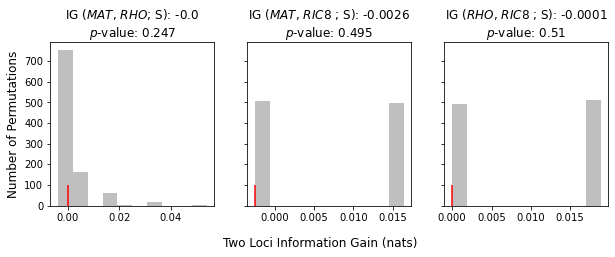

In [18]:
## Plot results
## Call figure
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(IG_pMATRHO,color='grey',alpha=0.5)
plt.vlines(IG_MATRHO, ymin=0, ymax=100, color='r')
plt.ylabel('Number of Permutations',fontsize=12)
k = np.sum(IG_pMATRHO > IG_MATRHO)/float(len(IG_pMATRHO))
plt.title("IG ($MAT$, $RHO$; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRHO,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[1])
plt.hist(IG_pMATRIC8,color='grey',alpha=0.5)
plt.vlines(IG_MATRIC8, ymin=0, ymax=100, color='r')
k = np.sum(IG_pMATRIC8 > IG_MATRIC8)/float(len(IG_pMATRIC8))
plt.title("IG ($MAT$, $RIC8$ ; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRIC8,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[2])
plt.hist(IG_pRHORIC8,color='grey',alpha=0.5)
plt.vlines(IG_RHORIC8, ymin=0, ymax=100, color='r')
k = np.sum(IG_pRHORIC8 > IG_RHORIC8)/float(len(IG_pRHORIC8))
plt.title("IG ($RHO$, $RIC8$ ; S): %s\n$p$-value: %s"%(
    str(np.round(IG_RHORIC8,4)),
    str(np.round(k,4))),fontsize=12)

fig.text(x=0.5,y=-0.05,s='Two Loci Information Gain (nats)',
         fontsize=12,va='center',ha='center');

In [19]:
## Run analysis with just the causal allele
## Gather samples with causleal alle
samples = pheno[(pheno.RIC8==1)].Genotyped

## Gather the phenotypes coded 0 - 3
Y = pheno.loc[samples,newpheno_label].values.reshape(-1,1)

## Main loci to test, the MAT type (coded 0 or 1)
## and genotypes at QTL3 (putatitve RHO) and RIC8
MAT = pheno.loc[samples,'MAT'].values.reshape(-1,1)
RHO = pheno.loc[samples,'RHO'].values.reshape(-1,1)

## Encode two-locus genotypes
MATRHO = MAT + 2 * RHO

## Run MI code, this is using natrual log (nats)
MIobs = fs.mutual_info_classif(np.hstack((Y,MAT,RHO,MATRHO)), Y.ravel(),discrete_features=True)

## label MIs
MI_MAT = MIobs[1]
MI_RHO = MIobs[2]
MI_MATRHO = MIobs[3]

## Calculate IGstrict of Hu et al
IG_MATRHO = MI_MATRHO - MI_MAT - MI_RHO

In [20]:
## Run permutations with RIC8, causle allele data only
MIperm = []

## Permute 
while len(MIperm) < nperms:
    origgenos = np.hstack((MAT,RHO))
    permgenos = np.random.permutation(origgenos)
    pMAT = permgenos[:,0].reshape(-1,1)
    pRHO = permgenos[:,1].reshape(-1,1)
    pMATRHO = pMAT + 2*pRHO
    
    miperm = fs.mutual_info_classif(np.hstack((Y,pMAT,pRHO,
                                               pMATRHO)), 
                                    Y.ravel(),
                                    discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pMAT = MIperm[:,1]
MI_pRHO = MIperm[:,2]
MI_pMATRHO = MIperm[:,3]

# IGstrict for permuted data
IG_pMATRHO = MI_pMATRHO - MI_pMAT - MI_pRHO

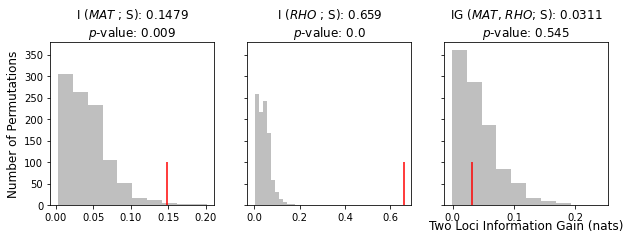

In [22]:
## Plot results
## Call figure
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(MI_pMAT,color='grey',alpha=0.5)
plt.vlines(MI_MAT, ymin=0, ymax=yobs, color='r')
k = np.sum(MI_pMAT > MI_MAT)/float(len(MI_pMAT))
plt.title("I ($MAT$ ; S): %s\n$p$-value: %s"%(
    str(np.round(MI_MAT,4)),
    str(np.round(k,4))),fontsize=12)

plt.ylabel('Number of Permutations',fontsize=12)

plt.sca(ax[1])
plt.hist(MI_pRHO,color='grey',alpha=0.5)
plt.vlines(MI_RHO, ymin=0, ymax=yobs, color='r')
k = np.sum(MI_pRHO > MI_RHO)/float(len(MI_pRHO))
plt.title("I ($RHO$ ; S): %s\n$p$-value: %s"%(
    str(np.round(MI_RHO,4)),
    str(np.round(k,4))),fontsize=12)

plt.sca(ax[2])
plt.hist(IG_pMATRHO,color='grey',alpha=0.5)
plt.vlines(IG_MATRHO, ymin=0, ymax=yobs, color='r')
k = np.sum(IG_pMATRHO > IG_MATRHO)/float(len(IG_pMATRHO))
plt.title("IG ($MAT$, $RHO$; S): %s\n$p$-value: %s"%(
    str(np.round(IG_MATRHO,4)),
    str(np.round(k,4))),fontsize=12)

plt.xlabel('Two Loci Information Gain (nats)',
         fontsize=12,va='center',ha='center');